In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re


sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.preselection.ranked_quadh

signal = ObjIter([Tree(fn) for fn in module.signal_list])
# signal = ObjIter([Tree(module.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
# signal_asym = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
qcd = ObjIter([Tree(module.QCD_B_List)])
# qcd_asym = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])
ttbar = ObjIter([Tree(module.TTJets)])
# ttbar = ObjIter([])
# qcd = ObjIter([])

100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


# Event Selection
## - Trigger applied | HLT_PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepCSV_4p5
## - Required at least 8 jets to pass preselection
## - Preselections: Jet $P_{T} > 20$ [GeV], Jet $|\eta| < 2.5$, Tight Jet ID
## - Top 8 Btagged jets selected
## - Jets are paired into di-jets using the QuadHRanker Algorithm
## - Di-Jets are paired into Quad-Jets using by minimizing the mass difference between pairs

In [3]:
bkg = qcd + ttbar
bkg.reweight(2.3)
bkg.set_systematics([0.2])

[None, None]

# MC Reweighting
## MC Background normalization needs to be corrected to match data normalization
## A rough correction of 2.3x is applied along with a 20\% uncertainty

In [4]:
(signal + bkg).apply(lambda t : build_collection(t, 'H\dY\d', 'higgs', ptordered=True))

[None, None, None, None, None]

In [5]:
del varinfo.higgs_m

# 4 Di-Jet mass spectrums 
## Di-Jets ordered by $P_{T}$

100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


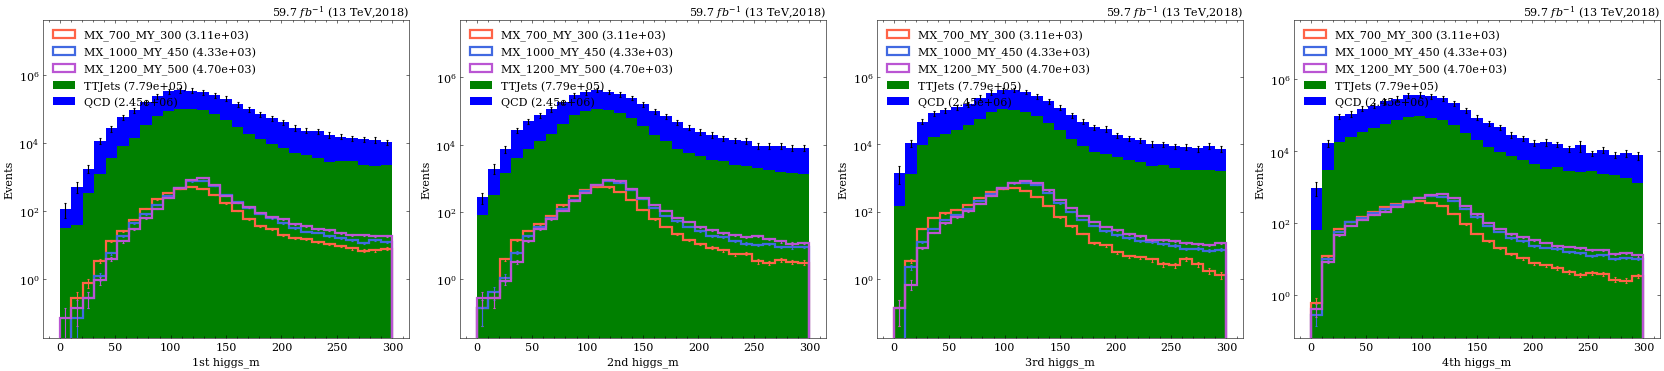

In [6]:
study.quick(
    signal+bkg, log=True, legend=True,
    varlist=[ f'higgs_m[:,{i}]' for i in range(4) ],
    binlist=[(0,300,30)]*4,
    dim=-1,

    saveas='mc_higgs_m',
)

# Background and signal di-jet masses are right on top of eachother

100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


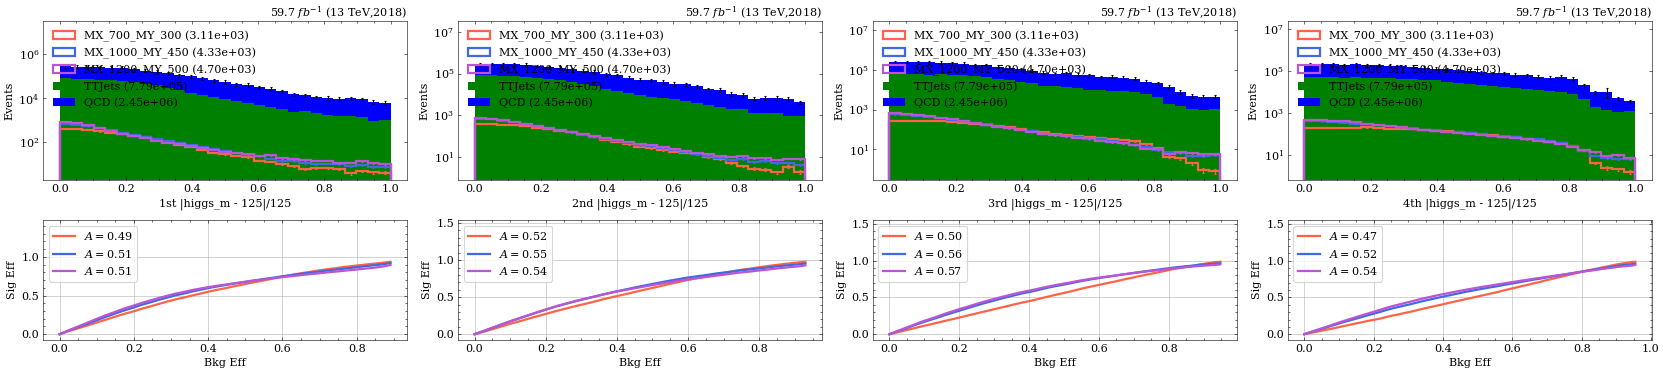

In [7]:
study.quick(
    signal+bkg, legend=True, log=True,
    transforms=lambda v : np.abs(v-125)/125,
    varlist=[ f'higgs_m[:,{i}]' for i in range(4) ],
    xlabels=[ f'{ordinal(i+1)} |higgs_m - 125|/125' for i in range(4) ],
    binlist=[(0,1,30)]*4,
    dim=-1,

    **study.auroc,
    e_c_ylabel='Sig Eff',
    e_c_xlabel='Bkg Eff',
    saveas='mc_higgs_m_125_cut',

)

# Not great separation between individual masses
## Perhaps Machine Learning can exploit more complicated relations between the 4 masses

# Higgs Mass CR using Machine learning techniques
## Using ML to separate signal from background using only the resonant masses 
## Investigating tools available in the hep_ml package

# Iron Transformer
## data preprocessing step

In [8]:
from hep_ml.preprocessing import IronTransformer

?IronTransformer

Init signature: IronTransformer(max_points=10000, symmetrize=False)
Docstring:     
Base class for all estimators in scikit-learn.

Notes
-----
All estimators should specify all the parameters that can be set
at the class level in their ``__init__`` as explicit keyword
arguments (no ``*args`` or ``**kwargs``).
Init docstring:
IronTransformer fits one-dimensional transformation for each feature.

After applying this transformations distribution of each feature turns into uniform.
This is very handy to work with features with different scale and complex distributions.

The name of transformer comes from https://en.wikipedia.org/wiki/Clothes_iron,
which makes anything flat, being applied with enough pressure :)

Recommended to apply with neural networks and other algorithms sensitive to scale of features.

:param symmetrize: if True, resulting distribution is uniform in [-1, 1], otherwise in [0, 1]
:param int max_points: leave so many points in monotonic transformation.
File:           /u

In [9]:
higgs_m = signal.higgs_m.cat.to_numpy()
iron = IronTransformer().fit(higgs_m)

In [10]:
(signal+bkg).apply(lambda t : t.extend(
    iron_higgs_m = ak.from_regular(iron.transform(t.higgs_m.to_numpy()).to_numpy())
))

[None, None, None, None, None]

## Maps a distribution to a uniform distribution between 0 - 1

100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


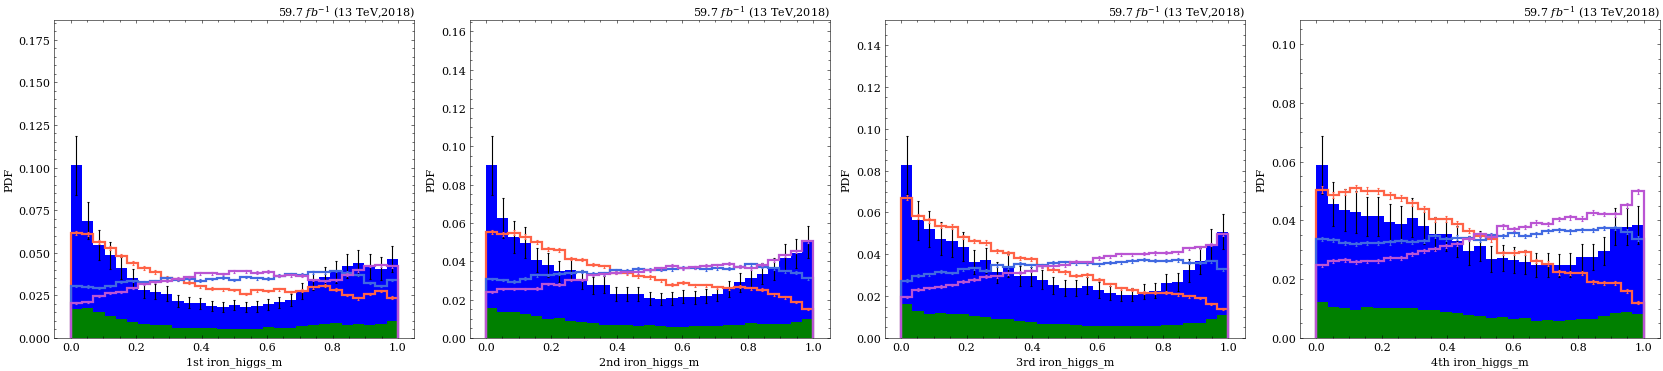

In [11]:
study.quick(
    signal+bkg, efficiency=True,
    varlist=[ f'iron_higgs_m[:,{i}]' for i in range(4) ],
    # binlist=[(-2,2,30)]*4,
    dim=-1,

    saveas='iron_higgs_m',

)

# Boosted Decision Tree Classifier

In [12]:
bdt_classifier = BDTClassifier(features=['higgs_m[:,0]','higgs_m[:,1]','higgs_m[:,2]','higgs_m[:,3]'])

In [13]:
train_signal = signal.subset(nentries=20000) # train on randomly selected events from each signal tree: total_signal = n_signal_trees * nentries
train_bkg = bkg.subset(nentries=30000) # train on randomly selected events from each bkg tree: total_bkg = n_bkg_trees * nentries

bdt_classifier.train(train_bkg, train_signal)

In [14]:
test_signal = signal.subset(nentries=20000)
test_bkg = bkg.subset(nentries=30000)

bdt_classifier.print_results(test_bkg, test_signal)

--- BDT Classifier Results ---
AUROC = 0.711


In [15]:
bdt_classifier.save('bdt_resonant_mass_classifier')

In [16]:
(signal+bkg).apply(lambda t : t.extend(
    bdt_higgs_m=bdt_classifier.predict_tree(t)
))

[None, None, None, None, None]

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


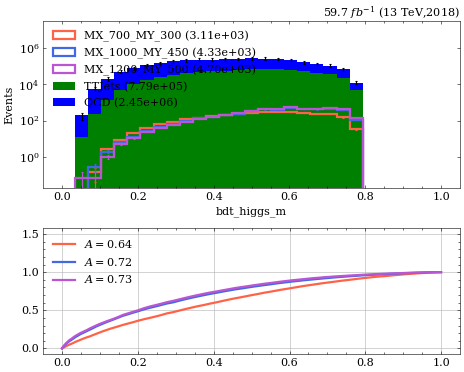

In [18]:
varinfo.bdt_higgs_m = dict(bins=(0,1,30))
study.quick(
    signal+bkg,
    varlist=['bdt_higgs_m'],
    # efficiency=True,
    log=True, legend=True,
    
    empirical=True,
    e_show=False, 
    e_sf=True,
    e_correlation=True, e_c_method=None, e_c_label_stat='area',

    saveas='bdt_score'
)

# Di-Jet masses as a function of bdt score

100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


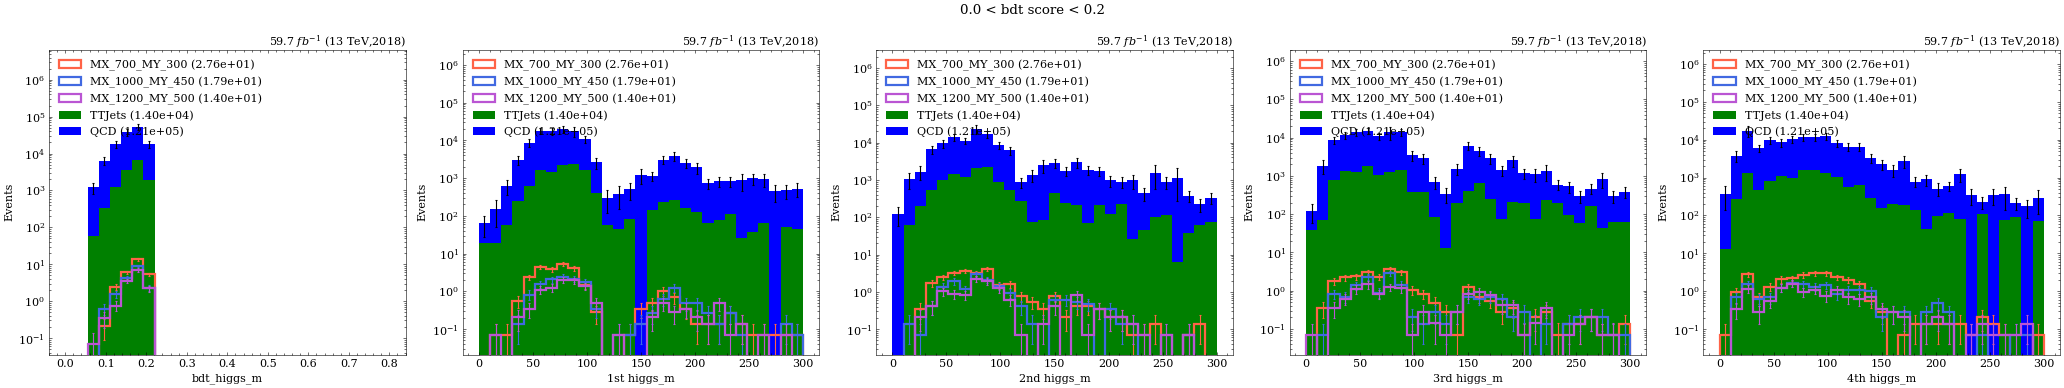

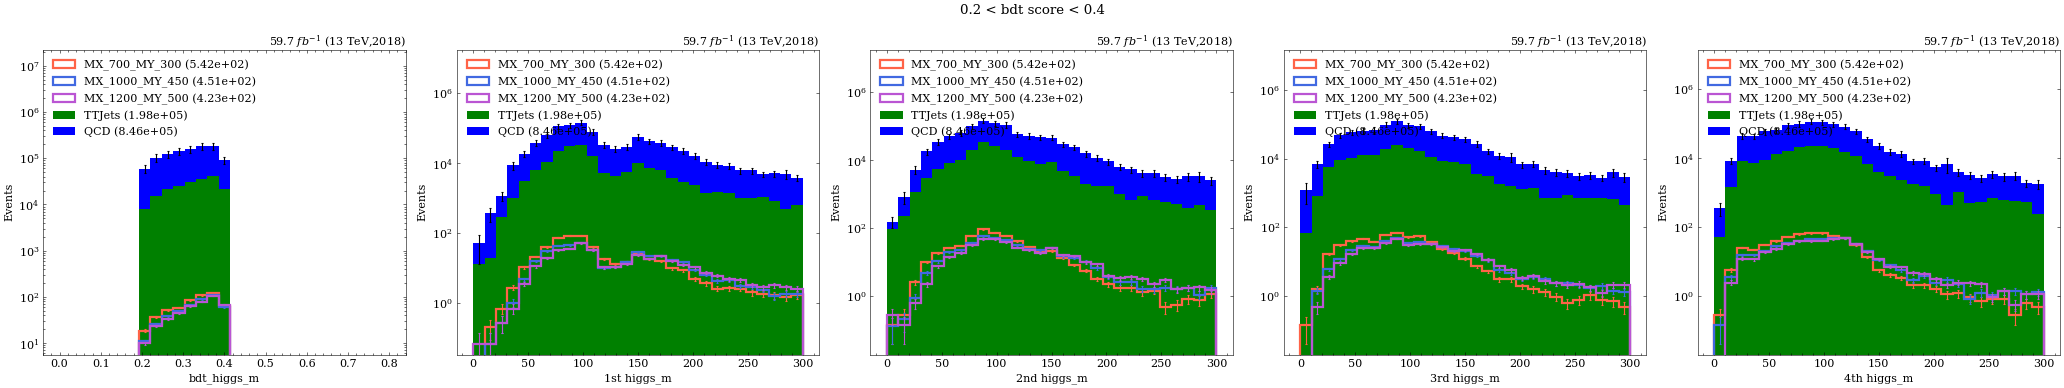

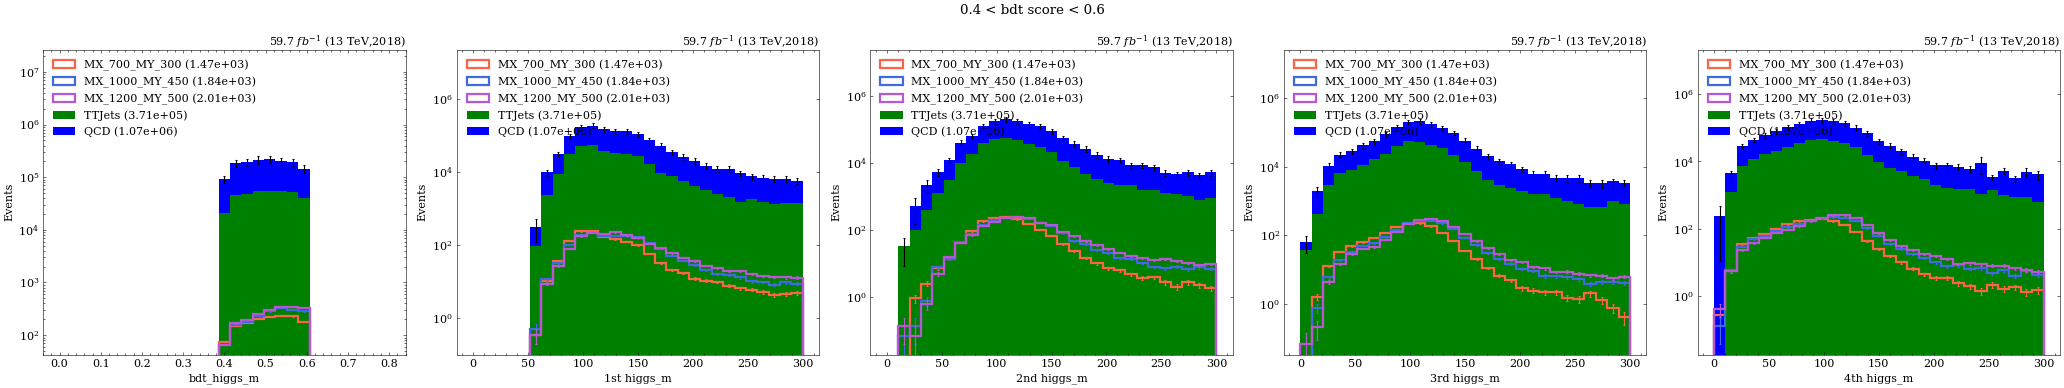

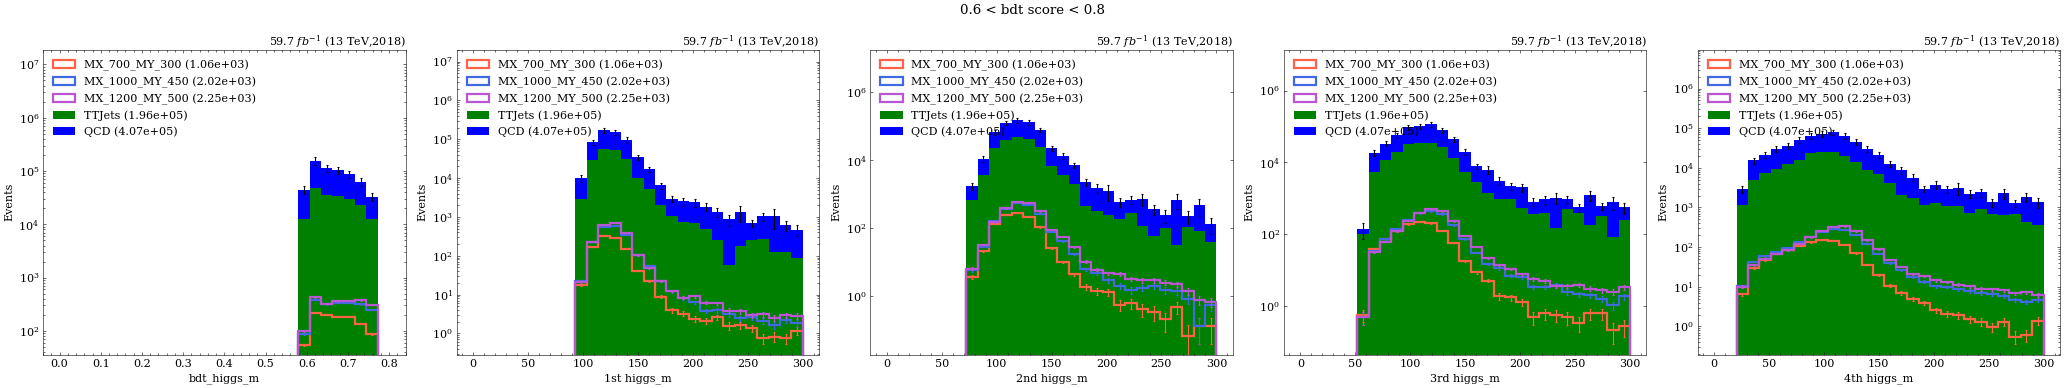

In [19]:
for i, (lo,hi) in enumerate(zip([0.,0.2,0.4,0.6],[0.2,0.4,0.6,0.8])):
    study.quick(
        signal+bkg, log=True, dim=-1, legend=True,
        masks=lambda t: (t.bdt_higgs_m>lo)&(t.bdt_higgs_m<hi),
        varlist=['bdt_higgs_m']+[f'higgs_m[:,{j}]' for j in range(4)],
        binlist=[(0,0.8,30)]+[(0,300,30)]*4, 
        suptitle=f'{lo} < bdt score < {hi}',
        saveas=f'bdt_score_cut_{lo}_{hi}'
    )
    

## We can see that at low bdt score the higgs peak (125) is almost completely removed
## As we get to higher bdt score the higgs peak returns
## We also see a trend to higher di-jet mass with higher bdt score (more obvious in the higher $P_{T}$ di-jets)

# BDT score vs X mass
## BDT is fairly uncorrelated with X mass, which is good! 

100%|██████████| 1/1 [00:10<00:00, 10.86s/it]


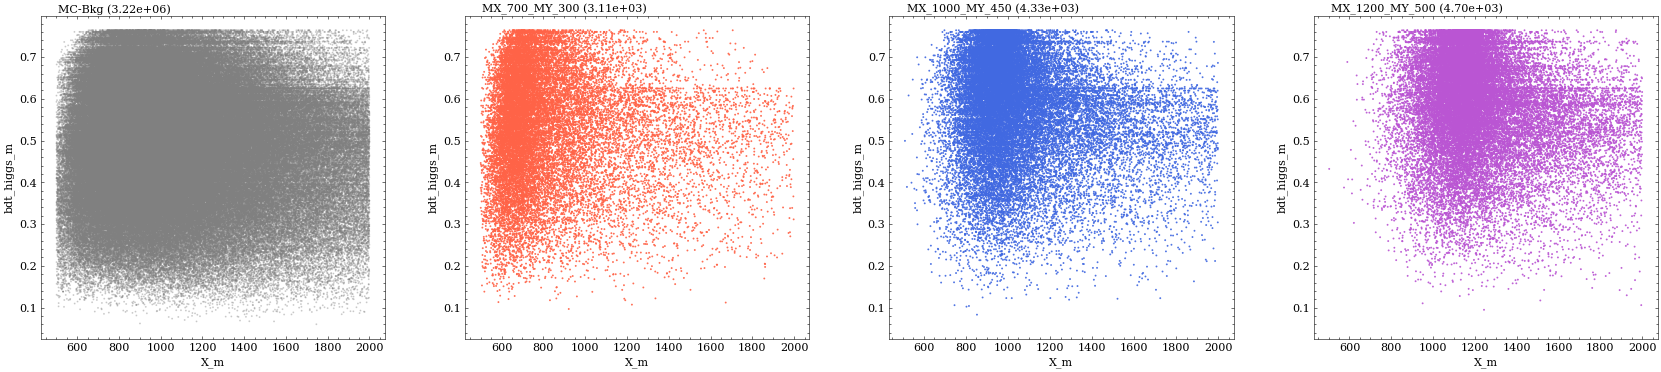

In [20]:
study.quick2d(
    signal+bkg,
    # masks=lambda t:t.bdt_higgs_m>0.35,
    varlist=['X_m','bdt_higgs_m'],
    scatter=True,
    saveas='X_m_vs_bdt'
)

# BDT Score vs Loose Btag multiplicity
## Although there isn't as great of separation in BDT score as there is in btag multiplicity
## We can still define sufficienctly good ABCD regions in this phase space

100%|██████████| 1/1 [00:06<00:00,  6.11s/it]


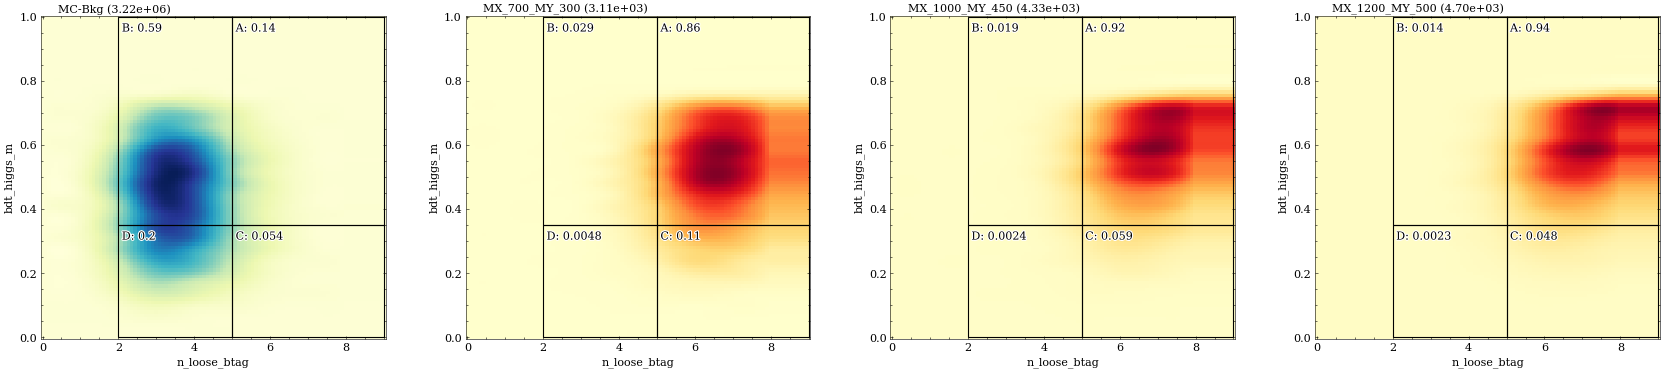

In [21]:
study.quick2d(
    signal+bkg,
    # masks=lambda t:t.bdt_higgs_m>0.35,
    varlist=['n_loose_btag','bdt_higgs_m'],
    interp=True,
    exe=draw_abcd(x_r=(2,5,9),y_r=(0,0.35,1)),
    saveas='mc_abcd_ar'
)

In [22]:
ar_bdt = ABCD(
    features=['X_m','X_pt'],
    a=lambda t : (t.n_loose_btag >= 5) &                         (t.bdt_higgs_m > 0.35),
    b=lambda t : (t.n_loose_btag >= 2) & (t.n_loose_btag <  5) & (t.bdt_higgs_m > 0.35),
    c=lambda t : (t.n_loose_btag >= 5) &                         (t.bdt_higgs_m < 0.35),
    d=lambda t : (t.n_loose_btag >= 2) & (t.n_loose_btag <  5) & (t.bdt_higgs_m < 0.35),
)

# What are sensitivities do we expect in each region?

100%|██████████| 1/1 [00:21<00:00, 21.89s/it]


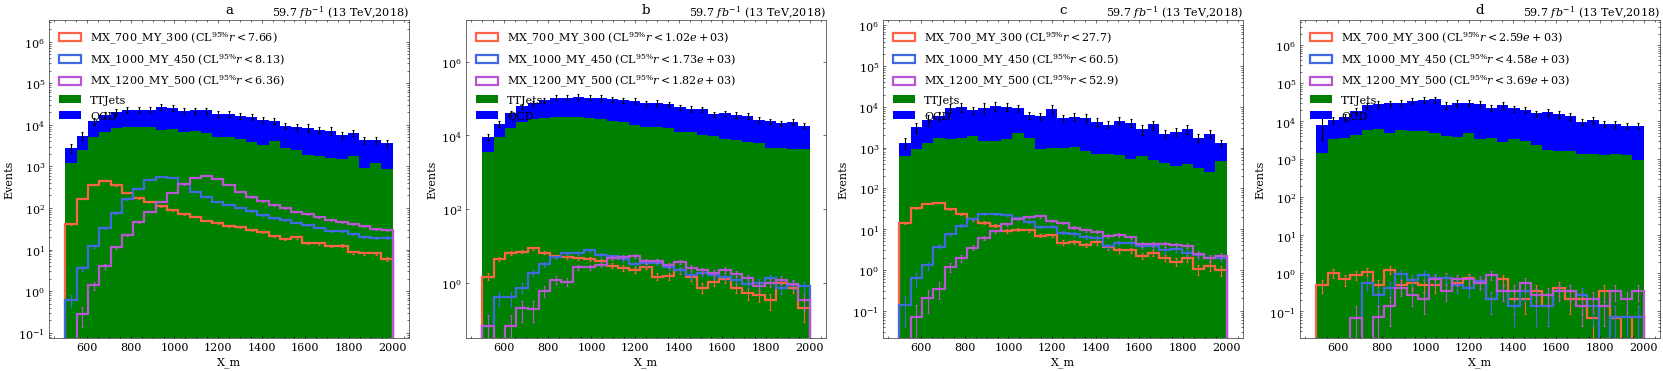

In [23]:
fig,axs=study.get_figax(4, dim=-1)
for i,region in enumerate(('a','b','c','d')):
    study.quick(
        signal+bkg, legend=True, log=True,
        masks=getattr(ar_bdt, region),
        varlist=['X_m'],
        title=region,
        limits=True,
        figax=(fig, axs.flat[i]),
    )
study.save_fig(fig, '', 'mc_ar_limits')

# Analysis Region
## We can see that the B and D regions are very insensitive to the signal contamination 
## The C region also shows worse sensitivity than the A region, however is it enough to call it a control region?

In [24]:
ar_bdt.train(bkg)
ar_bdt.print_results(bkg)

--- ABCD Results ---
k = 2.632e-01
k*(b/a)-1  = 14.17%
BDT(b)/a-1 = 12.80%



100%|██████████| 4/4 [00:06<00:00,  1.70s/it]


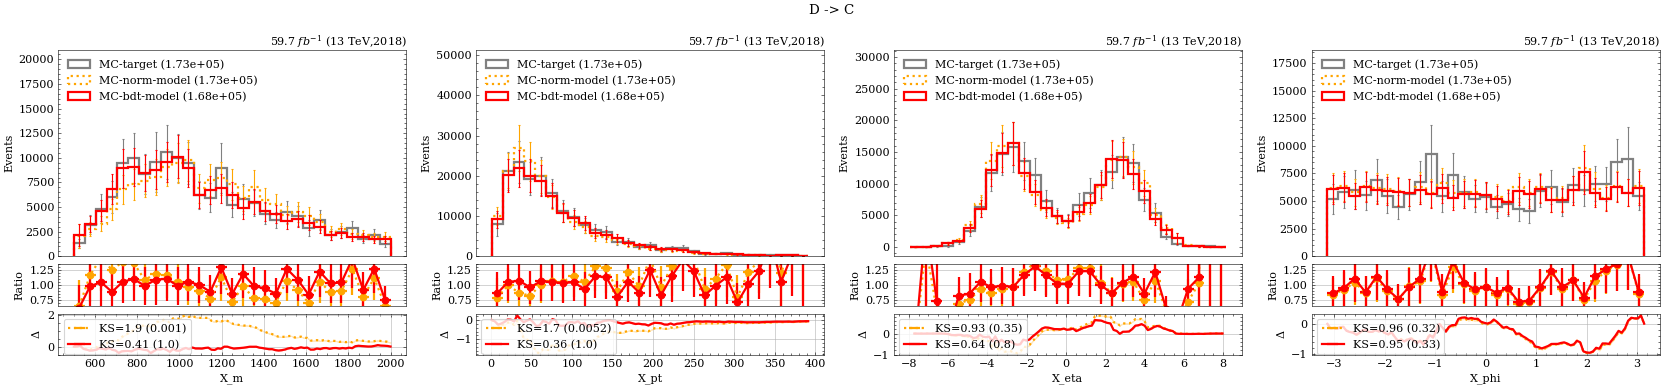

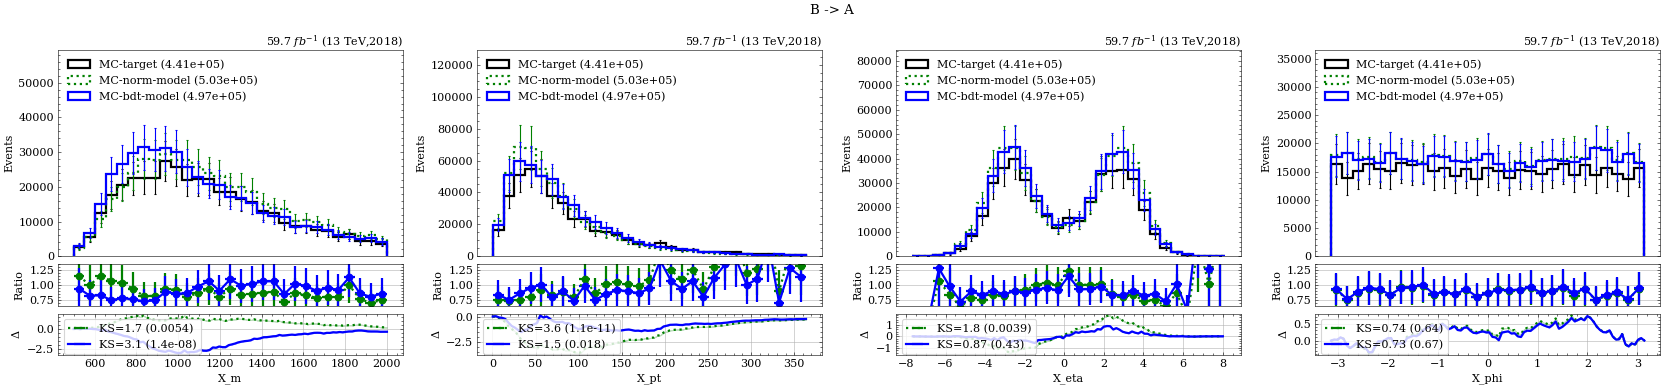

In [34]:
study.quick_region(
    bkg,bkg,bkg, legend=True, 
    h_color=['grey','orange','red'],
    h_linestyle=['-',':','-'],
    dim=-1,
    label=['MC-target','MC-norm-model','MC-bdt-model'],
    masks=[ar_bdt.c]*len(bkg)+[ar_bdt.d]*len(bkg)+[ar_bdt.d]*len(bkg),
    scale=[1]*len(bkg)+[ar_bdt.scale_tree]*len(bkg)+[ar_bdt.reweight_tree]*len(bkg),
    varlist=['X_m', 'X_pt','X_eta','X_phi'],
    ratio=True, r_ylim=(0.65,1.35), 
    **study.kstest,

    suptitle='D -> C',
    saveas='mc_ar_DC'
)

study.quick_region(
    bkg,bkg,bkg, legend=True, 
    h_color=['black','green','blue'],
    h_linestyle=['-',':','-'],
    dim=-1,
    label=['MC-target','MC-norm-model','MC-bdt-model'],
    masks=[ar_bdt.a]*len(bkg)+[ar_bdt.b]*len(bkg)+[ar_bdt.b]*len(bkg),
    scale=[1]*len(bkg)+[ar_bdt.scale_tree]*len(bkg)+[ar_bdt.reweight_tree]*len(bkg),
    varlist=['X_m', 'X_pt','X_eta','X_phi'],
    ratio=True, r_ylim=(0.65,1.35),
    **study.kstest,

    suptitle='B -> A',
    saveas='mc_ar_BA'
)

# Validation Region

100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


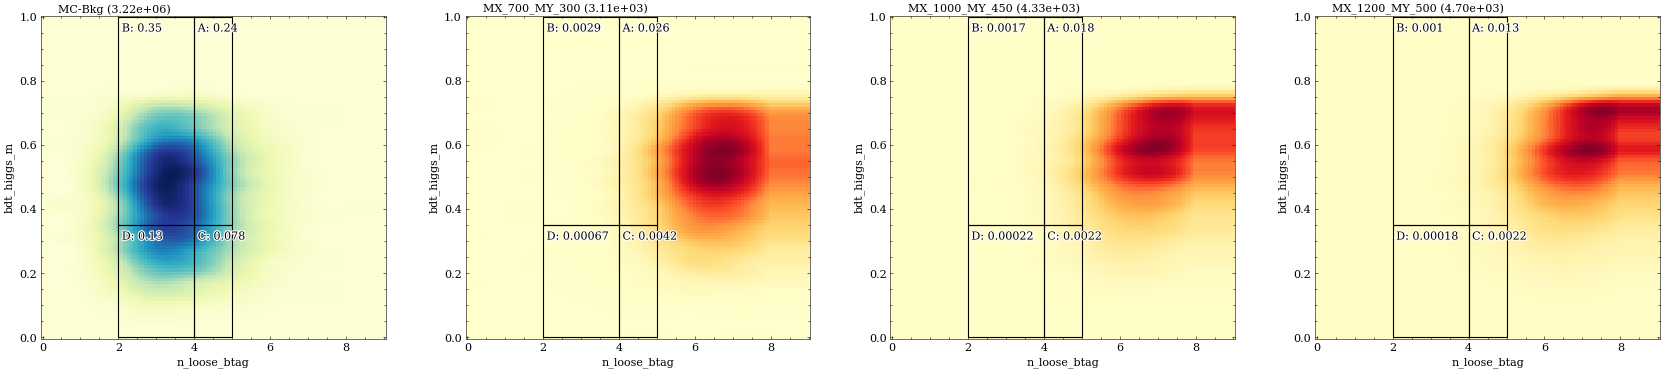

In [35]:
study.quick2d(
    signal+bkg,
    # masks=lambda t:t.bdt_higgs_m>0.35,
    varlist=['n_loose_btag','bdt_higgs_m'],
    interp=True,
    exe=draw_abcd(x_r=(2,4,5),y_r=(0.,0.35,1.0)),
    saveas='mc_vr_abcd'
)

In [36]:
vr_bdt = ABCD(
    features=['X_m','X_pt'],
    a=lambda t : (t.n_loose_btag == 4) &                         (t.bdt_higgs_m > 0.35),
    b=lambda t : (t.n_loose_btag >= 2) & (t.n_loose_btag <  4) & (t.bdt_higgs_m > 0.35),
    c=lambda t : (t.n_loose_btag == 4) &                         (t.bdt_higgs_m < 0.35),
    d=lambda t : (t.n_loose_btag >= 2) & (t.n_loose_btag <  4) & (t.bdt_higgs_m < 0.35),
)

100%|██████████| 1/1 [00:16<00:00, 16.24s/it]


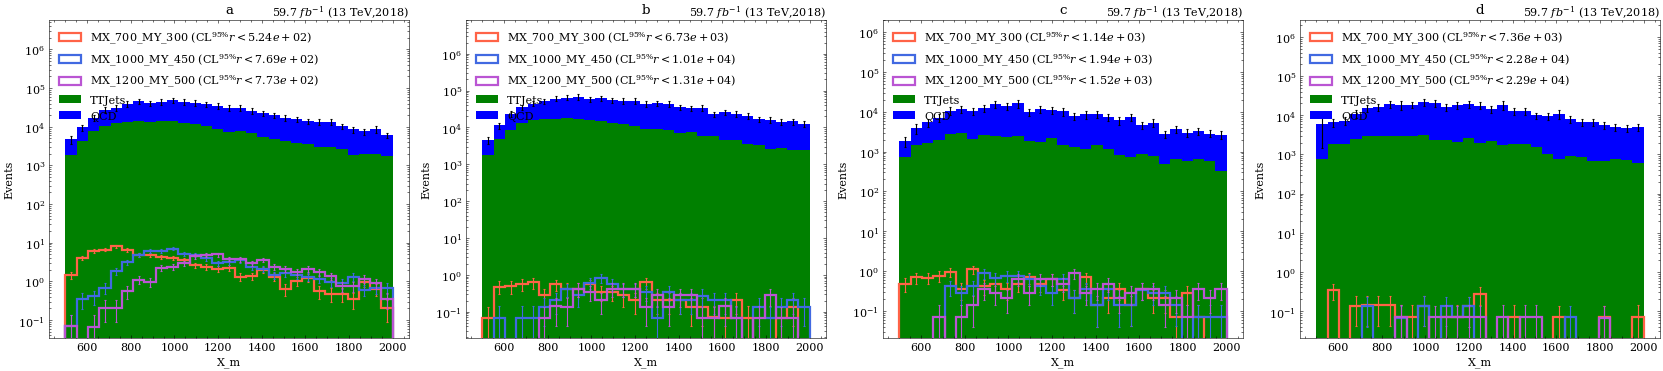

In [37]:
fig,axs=study.get_figax(4, dim=-1)
for i,region in enumerate(('a','b','c','d')):
    study.quick(
        signal+bkg, legend=True, log=True,
        masks=getattr(vr_bdt, region),
        varlist=['X_m'],
        title=region,
        limits=True,
        figax=(fig, axs.flat[i])
    )
study.save_fig(fig, '', 'mc_vr_limits')

# Very insensitive to the signal in the validation region
## Next steps
## - Apply this BDT classifier on data in this validation region
## - Compare with MC background
## - See how ABCD method performs on data in the validation region

In [38]:
vr_bdt.train(bkg)
vr_bdt.print_results(bkg)

--- ABCD Results ---
k = 6.238e-01
k*(b/a)-1  = -7.03%
BDT(b)/a-1 = -5.72%



100%|██████████| 4/4 [00:06<00:00,  1.53s/it]


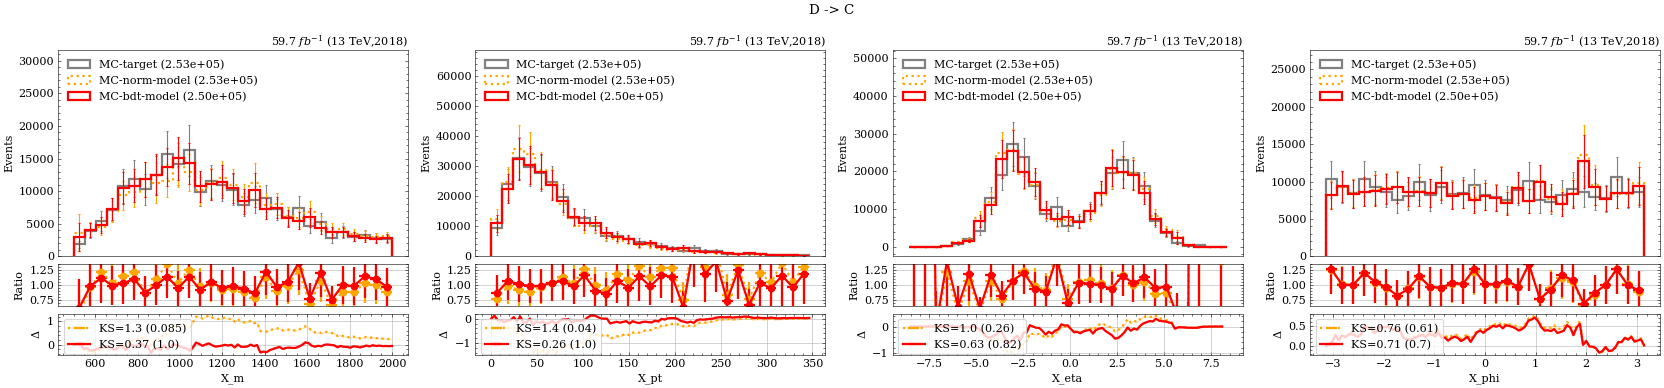

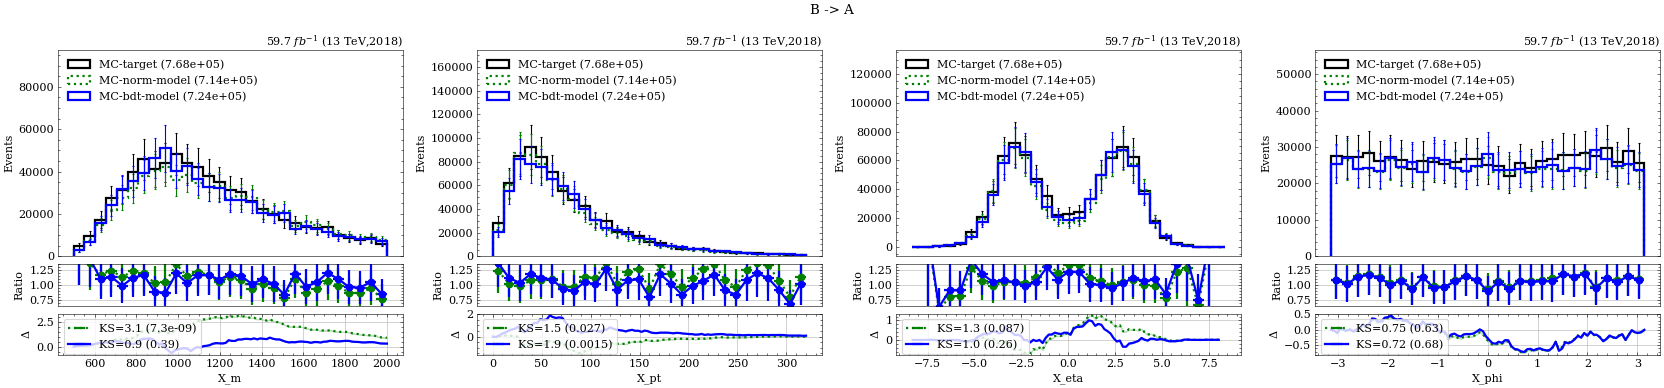

In [39]:
study.quick_region(
    bkg,bkg,bkg, legend=True, 
    h_color=['grey','orange','red'],
    h_linestyle=['-',':','-'],
    dim=-1,
    label=['MC-target','MC-norm-model','MC-bdt-model'],
    masks=[vr_bdt.c]*len(bkg)+[vr_bdt.d]*len(bkg)+[vr_bdt.d]*len(bkg),
    scale=[1]*len(bkg)+[vr_bdt.scale_tree]*len(bkg)+[vr_bdt.reweight_tree]*len(bkg),
    varlist=['X_m', 'X_pt','X_eta','X_phi'],
    ratio=True, r_ylim=(0.65,1.35), 
    **study.kstest,

    suptitle='D -> C',
    saveas='mc_vr_DC'
)

study.quick_region(
    bkg,bkg,bkg, legend=True, 
    h_color=['black','green','blue'],
    h_linestyle=['-',':','-'],
    dim=-1,
    label=['MC-target','MC-norm-model','MC-bdt-model'],
    masks=[vr_bdt.a]*len(bkg)+[vr_bdt.b]*len(bkg)+[vr_bdt.b]*len(bkg),
    scale=[1]*len(bkg)+[vr_bdt.scale_tree]*len(bkg)+[vr_bdt.reweight_tree]*len(bkg),
    varlist=['X_m', 'X_pt','X_eta','X_phi'],
    ratio=True, r_ylim=(0.65,1.35),
    **study.kstest,

    suptitle='B -> A',
    saveas='mc_vr_BA'
)